In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import optimistix
from timeit import default_timer as timer

In [2]:
ORIGIN = jnp.array((0, 0))
SEED = jax.random.PRNGKey(0)


def _length(a):
    return jnp.linalg.norm(a, axis=1)

def _soft_plus(value):
    return jax.nn.softplus(50 * value) / 50

def _soft_minus(value):
    return -jax.nn.softplus(50 * -value) / 50

#########################
## Transformations

def translate(sdf, offset):
    offset = jnp.array(offset)
    def f(p):
        return sdf(p - offset)
    return f

def rotate(sdf, angle):
    s = jnp.sin(angle)
    c = jnp.cos(angle)
    R = jnp.array(
        [
            [c, -s],
            [s, c],
        ]
    )
    def f(p):
        return sdf((R @ p.T).T)
    return f

def rotate_around_center(sdf, angle, center):
    center = jnp.array(center)

    def f(p):
        v = translate(rotate(translate(sdf, -center), angle), center)(p)
        return v
    return f

# Map SDF function into one with interior/exterior points mapped to (roughly) 1 and 0, respectively.
def inside(sdf, scale=100):
   def f(p):
       return 1 - jax.nn.sigmoid(scale * sdf(p))
   return f


#########################
## Primitive SDFs

def circle(radius=1, center=(0, 0)):
    center = jnp.array(center)
    def f(p):
        return _length(p - center) - radius
    return f

def rectangle(size=(1,1), center=(0, 0)):
    center = jnp.array(center)
    size = jnp.array(size)

    def f(p):
        q = jnp.abs(p - center) - size / 2
        return _length(_soft_plus(q)) + _soft_minus(jnp.amax(q, axis=1))
    return f

def bottom_half_plane(p):
    return p[:, 1]


#########################
## Combinators

def intersection(sdf1, sdf2):
    def f(p):
        return jnp.maximum(sdf1(p), sdf2(p))
    return f

def union(sdf1, sdf2):
    def f(p):
        return jnp.minimum(sdf1(p), sdf2(p))
    return f


#########################
## Analysis

## TODO: combine sample points and bounds into single object since they're always related.

def area(sdf, points, bounds=(-1, 1)):
    samples = inside(sdf)(points)
    return samples.mean() * (bounds[1] - bounds[0])**2

def centroid(sdf, points):
    samples = inside(sdf)(points)
    return jnp.average(points, weights=samples, axis=0)



def render(sdf, bounds=(-1, 1), n=500):
    x = jnp.linspace(bounds[0], bounds[1], n)
    X, Y = jnp.meshgrid(x, x)
    grid_points = jnp.column_stack((X.flatten(), Y.flatten()))
    plt.imshow(1 - inside(sdf)(grid_points).reshape(n, n)
               , cmap="gray"
               , origin="lower"
               , extent=[bounds[0], bounds[1],bounds[0], bounds[1]])

## Boat shape optimization

Try to simultaniously optimize the shape and equilibirum position of a boat made up of stacked rectangles.

In [57]:
RELATIVE_DENSITY = 0.5
SAMPLE_SIZE = 10000
INTEGRATION_BOUNDS = (-3, 3)

In [4]:
def update_position(original_shape, original_shape_center, p1, p2):
    return translate(rotate_around_center(original_shape, jnp.atan(p1), original_shape_center), (0, p2))

def alignment_cost(shape, points):
    center_of_gravity = centroid(shape, points)
    
    shape_weight = RELATIVE_DENSITY * area(shape, points, bounds=INTEGRATION_BOUNDS)

    displacement = intersection(bottom_half_plane, shape)
    center_of_buoyancy = centroid(displacement, points)

    displacement_weight = area(displacement, points, bounds=INTEGRATION_BOUNDS)

    gravity_cost = displacement_weight - shape_weight
    torque_cost = (center_of_buoyancy - center_of_gravity)[0]

    costs = jnp.array([gravity_cost, torque_cost])
    return jnp.dot(costs, costs)

def center_of_gravity(shape, points):
    return centroid(shape, points)

def center_of_buoyancy(shape, points):
    displacement = intersection(bottom_half_plane, shape)
    return centroid(displacement, points)

In [38]:
def optimize_params(cost, params, points):
    solver = optimistix.BFGS(rtol=1e-5, atol=1e-6)
    start = timer()
    solution = optimistix.minimise(cost, solver, params, points)
    elapsed = timer() - start
    print("{0} steps in {1:.2f} seconds".format(
            solution.stats.get('num_steps'),
            elapsed))
    return solution.value

In [52]:
if True: # Hack to create local scope.
    shape = translate(rotate(rectangle((1,0.5)), jnp.pi), (0, 0.1))
    points = jax.random.uniform(SEED, (SAMPLE_SIZE, 2), jnp.float32, *INTEGRATION_BOUNDS)
    cog = center_of_gravity(shape, points)
    initial_params = jnp.array(
        [ 0. # y position
        , 0. # tan(angle) around center of gravity
        ])

    def params_to_shape(params):
        return update_position(shape, cog, params[0], params[1])
    
    def cost(params, points):
        return alignment_cost(params_to_shape(params), points)

16 steps in 2.24 seconds


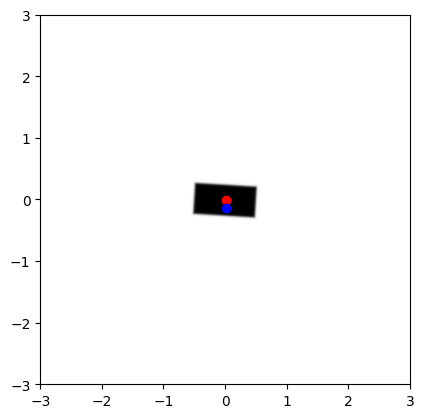

In [41]:
    params = optimize_params(cost, initial_params, points)

    end_shape = params_to_shape(params)
    render(end_shape, bounds=INTEGRATION_BOUNDS)
    plt.scatter(*center_of_gravity(end_shape, points), c="red")
    plt.scatter(*center_of_buoyancy(end_shape, points), c="blue")

# Optimize geometry to try and make a boat with fixed area with maximum height above waterline

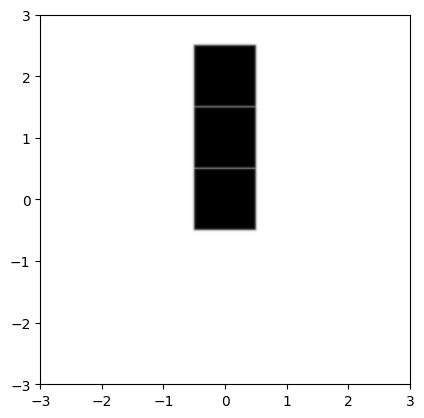

In [58]:
points = jax.random.uniform(SEED, (SAMPLE_SIZE, 2), jnp.float32, *INTEGRATION_BOUNDS)
initial_params = jnp.array(
    [ 0. # y position
    , 0. # tan(angle) around center of gravity
    , 1. # r1 width
    , 1. # r2 width
    , 1. # r3 width
    ])


def params_to_shape(params):
    shape = union(rectangle(size = (params[2], 1), center = (0, 0)),
                    union(rectangle(size = (params[3], 1), center = (0, 1)),
                        rectangle(size = (params[4], 1), center = (0, 2))))
    cog = center_of_gravity(shape, points)
    return update_position(shape, cog, params[0], params[1])

render(params_to_shape(initial_params), INTEGRATION_BOUNDS)

In [59]:
def cost(params, points):
    shape = params_to_shape(params)
    target_area = 3
    area_cost = (target_area - area(shape, points, INTEGRATION_BOUNDS))**2
    distance_from_3 = shape(jnp.array([[0, 3]]))
    return area_cost + alignment_cost(shape, points) + 2.0**distance_from_3[0]


62 steps in 5.98 seconds
[-5.7344056e-07  4.7073964e-02  2.9456320e+00 -1.2505856e-01
 -3.9731052e-02]


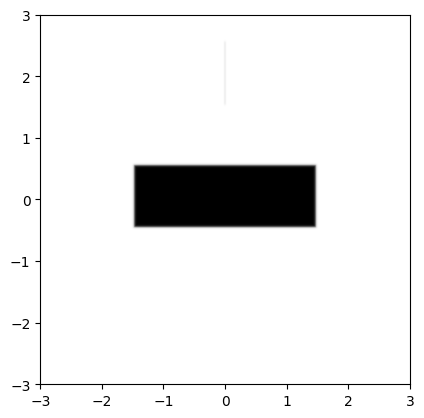

In [61]:

params = optimize_params(cost, initial_params, points)
print(params)

end_shape = params_to_shape(params)
render(end_shape, bounds=INTEGRATION_BOUNDS)
